# <font color = 'black'> **Solving Matrix Cascade Equations (MCEqs)** </font>

## <font color = 'purple'> **Background on MCEq** </font>

MCEqs are used to numerically solve for particle cascade equations. It computers *inclusive* particle fluxes. This means that the primary cosmic-ray spectrum has been integrated over and we will use it in air-shower mode to study the average behavior of the development of the air showers initiated by the cosmic ray nucleus.

<font color = 'darkred'> **Unit of energy is in GeV.** </font>

## <font color = 'purple'> **Imports** </font>

In [2]:
from MCEq.core import config, MCEqRun
import crflux.models as crf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

## <font color = 'purple'> **Ex 2.1:**  Muon number & energy</font>

We will compare a detailed calculation of particle numbers and energies to simple estimates from the Heitler-Matthews model. For this exercise, you do not need to run MCEq on a grid of atmospheric depths. By default, it will give you solutions for particle spectra at sea level.

### <font color = 'darkblue'> **Part A** </font>
> Run MCEq for a vertical 10 PeV proton shower. Determine the total number of muons $N_μ$ ($μ^+ + μ^-$) in the shower and compare it to what you would expect from the Heitler-Matthews model (use the range 0.87 ≤ α ≤ 0.93 as seen in class).

To determine the total number of muons in a proton shower, I will run the MCEq for a 10 PeV proton. Below is the code that will initialize this process. This code was retrieved from the online tutorial.
* Using the *mceq* variable, I can find the total number of muons (at sea level) by using the *n_mu* function. Note that I will assign the minimum energy cutoff to be 0.0 to include the entire range of muons.

In [2]:
# Running the MCEq 
mceq = MCEqRun(

# High-energy hadronic interaction model
interaction_model='SIBYLL23C',

# cosmic ray flux at the top of the atmosphere
primary_model = (crf.HillasGaisser2012, 'H3a'),

# zenith angle
theta_deg = 0.  # Set to 0 for vertical showers
)
mceq.set_single_primary_particle(1e7, pdg_id=2212) # 10 PeV proton - Units are in GeV

mceq.solve()

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [3]:
n_mu = mceq.n_mu(grid_idx=None, min_energy_cutoff=0) # Number of muons at sea level
print('The number of muons at sea level: {:.0f}'.format(n_mu))

The number of muons at sea level: 101995


From the Heitler-Matthews model, the number of muons can be calculated using:
$$N_\mu ^p = \left(\frac{E_o}{E_{dec}}\right)^\alpha$$
where $E_o$ is the primary energy, $E_{dec}$ is energy maxmum in which a pion will decay into a muon, and $\alpha = \frac{ln\left(\frac{2}{3} n_{tot}\right)}{ln(n_{tot})}$ . 
* In the lecture notes, $E_{dec} = 30 \; GeV$ and the primary energy is based on the primary particle of the shower, in this case it is the 10 PeV (1e7 GeV) proton.

In [4]:
## HM Model
Eo = 1e7   # Primary energy - Units of GeV
Ec = 30    # Energy threshold in which pions will decay into muons - Units of GeV (from slides)
beta_min = 0.87
beta_max = 0.93

low_HM_model = (Eo / Ec)**(beta_min)
high_HM_model = (Eo / Ec)**(beta_max)

print('The number of muons from Heitler-Matthews model is between {:.0f} and {:.0f}'.format(low_HM_model, high_HM_model))


The number of muons from Heitler-Matthews model is between 63812 and 136860


In [16]:
# Compare
print('N = Number of Muons')
print('MCEq: N = {:.0f}'.format(n_mu))
print('Heitler-Matthews Model: {:.0f} < N < {:.0f}'.format(low_HM_model, high_HM_model))


N = Number of Muons
MCEq: N = 101995
Heitler-Matthews Model: 63812 < N < 136860


Therefore, the number of muons at sea level calculated from the MCEq code is in the range that the Heitler-Matthews model predicted, where $\beta$ ranged from $0.87$ to $0.93$. 

### <font color = 'darkblue'> **Part B** </font>
> Determine the energy spectrum of muons in the shower, given by the number of muons in a certain energy bin divided by the bin width, $\frac{dN_\mu}{dE_\mu}$. Using this distribution, calculate the average muon energy in the shower. Compare it to the assumed muon energy in the Heitler-Matthews model, knowing that muons carry approximately 80% of the energy of the pion after decay.

To find the flux of muons, I will use the *get_solutions* function from the mceq and integrate over all the positively and negatively charged muons, I will call this $dN$. To calculate the different in muon energy, I will use the *e_widths* function, which denoted the width of the energy bins, meaning the difference in energy, $dE$.
* Therefore to calculate the energy spectrum of muons, I will divide the flux of muons by the different in energy to obtain an energy spectrum of the muons. I will call this $dNdE$ . 

*Note that the energy spectrum is denoted by the **e_grid** function.*

I can use the Simpson integration technique from *scipy* to determine the average muon energy. 
* This function integrated a function using samples along a given axis using the composite Simpson's rule.
* Eg. Integrating $y(x)$ along $x$: scipy.integrate.simpson(y, x = x)


First, I will find the total energy of the muons, which is 
$$E_{tot} = \int  E \, \frac{dN}{dE}$$
* Sampled along the energy spectrum, $E$ 

Then, I will calculate the total energy spectrum:
$$E_{spec} = \int \frac{dN}{dE}$$ 
* Sampled along E

Therefore, the mean muon energy is given by:
$$E_{avg , \mu} = \frac{E_{tot}}{E_{spec}}$$ 
* Given in units of GeV

In [6]:
dN = mceq.get_solution('mu+', integrate = True) + mceq.get_solution('mu-', integrate = True)   # Flux of Muons 
dE = mceq.e_widths  # width of energy bin
dNdE = dN / dE  # Energy spectrum of muons

E = mceq.e_grid

## Finding the mean energy using Simpson integration

E_tot = scipy.integrate.simpson(E*dNdE, x = E) # Total energy 
E_spec_tot = scipy.integrate.simpson(dNdE, x = E) # Total energy spectrum; the argument is sampled by the energy grid, E

Eavg_mu = E_tot / E_spec_tot   # Mean energy 

print('The mean muon energy from MCEq is {} GeV'.format(Eavg_mu))

The mean muon energy from MCEq is 8.7994929014951 GeV


From the Heitler-Matthews model, we know that $E_{dec}$ is the energy where energy values under it will decay into muons.
$$E_{dec} = 30 GeV$$

From the lecture notes, the energy of muons carry about 80% of the energy of pions. Therefore, the muon energy from the Heitler-Matthews model is 
$$E_\mu = 0.8 \; E_{dec} = 0.8 \; (30 \, GeV) = 24.0 \, GeV$$

In [7]:
## HM Model
E_c = 30 # Energy threshold of a pion - anything below turns into a muon; units of GeV
E_mu = 0.8 * E_c

print('The assumed muon energy in the Heitler-Matthews model is {} GeV'.format(E_mu))

The assumed muon energy in the Heitler-Matthews model is 24.0 GeV


In [8]:
## Comparing values
ratio = E_mu / Eavg_mu
print('The muon energy from the Heitler-Matthews model is {:.2f} times greater than the MCEq approximation.'.format(ratio))

The muon energy from the Heitler-Matthews model is 2.73 times greater than the MCEq approximation.


**Question**: Why is the Heitler-Matthews model almost 3 times larger than the MCEq approximation?
* answer here

### <font color = 'darkblue'> **Part C** </font>
> Make a plot showing the muon energy spectrum for a $10\;PeV$ proton and an iron shower for $100 \; MeV$ ≤ $E_\mu$ ≤ $100\;TeV$. How do they differ?

Below is the code of creating a vertical cascade of an $10 \, PeV$ iron ($Fe$) shower. Most of the code is the same, however one major difference is the ID number.
* For an iron primary particle, I will use the ID number, **'corsika_id = 5626'**, when setting the primary particle of the shower.
* I will call this shower, *mceq_fe*

To calculate the number of muons at sea level, I will do the same process as before.

In [3]:
## Iron Shower

# Running the MCEq 
mceq_fe = MCEqRun(

# High-energy hadronic interaction model
interaction_model='SIBYLL23C',

# cosmic ray flux at the top of the atmosphere
primary_model = (crf.HillasGaisser2012, 'H3a'),

# zenith angle
theta_deg = 0.  # Set to 0 for vertical showers
)
mceq_fe.set_single_primary_particle(1e7, corsika_id = 5626) # 10 PeV Iron - Units are in GeV

mceq_fe.solve()

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [20]:
n_mu_fe = mceq_fe.n_mu(grid_idx=None, min_energy_cutoff=0) # Number of muons at sea level
print('The number of muons at sea level for a Fe primary: {:.0f}'.format(n_mu_fe))

## Comparing to proton primary with same energy
print('----------------------------')
print('Comparing Values')
print('The number of muons (at sea level) in a Fe shower is {:0.2f} greater than a proton shower (both have energy of 10 PeV)'.format(n_mu_fe/n_mu))

The number of muons at sea level for a Fe primary: 134754
----------------------------
Comparing Values
The number of muons (at sea level) in a Fe shower is 1.32 greater than a proton shower (both have energy of 10 PeV)


Q: Why does the number of muons increase in the Fe shower comapred to the proton shower for the same energy?
* Answer here

Below is the same process as before to find the mean muon energy from *mceq_fe*.

In [7]:
## Finding mean muon energy
dN_fe = mceq_fe.get_solution('mu+', integrate = True) + mceq_fe.get_solution('mu-', integrate = True)
dE_fe = mceq_fe.e_widths   # this is EXACTLY the same as dE
dNdE_fe = dN_fe / dE_fe # energy spectrum of muons in an iron shower

E_fe = mceq_fe.e_grid  # same as before

## Finding the mean energy using Simpson integration

E_tot_fe = scipy.integrate.simpson(E_fe*dNdE_fe, x = E_fe) # Total energy 
E_spec_tot_fe = scipy.integrate.simpson(dNdE_fe, x = E_fe) # Total energy spectrum; the argument is sampled by the energy grid, E
Eavg_mu_fe = E_tot_fe / E_spec_tot_fe   

print('The mean muon energy in an iron shower from MCEq is {} GeV'.format(Eavg_mu_fe))

The mean muon energy in an iron shower from MCEq is 11.215314610414152 GeV


In [21]:
print(dE[0], dE_fe[0]) # this shows that the energy spectrum is not dependent on the primary particle

0.020567176527571868 0.020567176527571868


Below is a plot of the 10 PeV iron and proton showers for the range of energies $100 \; MeV$ ≤ $E_\mu$ ≤ $100\;TeV$ .

First, I will define the energy range with a variable *mask*. This variable will be an array index that meets the energy range criteria with a Boolean.

Example:
$$\text{Ex} = \text{E} < 0.1$$ 
* 0.1 is equivalent to 100 MeV
* The variable $\text{Ex}$ will be an array with the values of $\text{True}$ where the index meets the criteria given.

Example 2: 
$$\text{Ex}_2 = (\text{E} < 0.1)\times(\text{E} > 1)$$ 
* 1 is equivalent to 1 GeV
* The variable $\text{Ex}_2$ will be an array where **both** conditions are met. 
* Imagine a $\text{True} = 1$ and $\text{False} = 0$. If only one condition is met, you have a $\text{True} \times \text{False} = 1\times0 = 0$, which correlates to a $\text{False}$. 

Therefore, the only way to get a $\text{True}$ is if you have a $\text{True} \times \text{True}$ .  

In [33]:
## We want a variable of to know which indices meet the energy range specified.
mask = (E > 0.1) * (E < 1e5)   # array of Booleans where the indices meet conditons

print(mask)  # Boolean for 121 indices of E

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]


In [40]:
## Only using the indices where the energy condition is met
print(len(E))
print(len(E[mask]))  # E values where the mask was True

121
60


Text(0, 0.5, 'Ratio Fe/p')

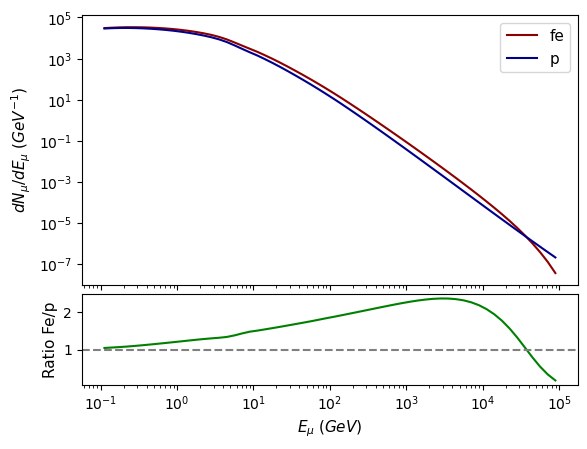

In [ ]:
fig, ax = plt.subplots(2, 1, sharex = True, gridspec_kw = {'height_ratios': (3,1) , 'hspace': 0.05})

ax[0].loglog(E[mask], dNdE_fe[mask], color = 'darkblue', label = 'fe') # plots a log scale
ax[0].loglog(E[mask], dNdE[mask], color = 'darkred', label = 'p')
ax[0].set_ylabel(r'$dN_\mu / dE_\mu \; (GeV^{-1})$', fontsize = 11)

ax[0].legend(fontsize = 11)

ax[1].plot(E[mask], dNdE_fe[mask]/dNdE[mask], color = 'green')
ax[1].axhline(1, color = 'grey', ls = '--')
ax[1].set_xlabel(r'$E_\mu \;(GeV)$', fontsize = 11)
ax[1].set_ylabel('Ratio Fe/p', fontsize = 11)

The plot above shows both the muon energy spectrum for both the case of an iron shower and a proton shower with energies of $10 \, PeV$ . However, the ratio plot below it shows the difference in the two plots. For the most part, the iron shower produces more muons than the proton shower. This is because heavier primary particles produce more electrons and muons because they have more intial collisons than lighter primary particles, such as protons. As a result of more intial collisions, they will have more particle cascades, which causes the increase in the number of muons at sea level.

I noticed with the ratio of the number of muons had an interesting trajectory, because for the most part, the iron shower had more muons up until $5 \times 10^4 \; E_\mu$ . For higher energies, the proton shower has more muons. This is because the primary energy will be divided per nucleon, meaning that when the energy is higher, the iron atom will have the energy distributed over 56 nucleons (26 protons and 30 neutrons) compared to the singular proton.
* Primary particles with more energy will increase the energy of the secondary particles, which is pions, which increases the collision rates of the particles. Since pions decay into muons once they are below $30\,GeV$ , this means that more muons are produced. 

## <font color = 'purple'> **Ex 2.2:**  Relation between muons and primary energy </font>

In the Heitler-Matthews model, the number of muons scales sub-linearly with
the primary energy: $$N_\mu \propto E_0^\alpha$$  with $\alpha < 1$ . We will study this relation using realistic shower calculations.

### <font color = 'darkblue'> **Part A** </font>
> Derive the total number of muons at the ground for proton-induced air showers at several primary energies between $1\,PeV$ and $1\,EeV$ using MCEq.
Plot them on logarithmic axes.

*Note that the energy range (in GeV) is between: $1 \times 10^6$ and $1 \times 10^9$ .* 

In [109]:
np.geomspace(1e6, 1e9, 20)

array([1.00000000e+06, 1.43844989e+06, 2.06913808e+06, 2.97635144e+06,
       4.28133240e+06, 6.15848211e+06, 8.85866790e+06, 1.27427499e+07,
       1.83298071e+07, 2.63665090e+07, 3.79269019e+07, 5.45559478e+07,
       7.84759970e+07, 1.12883789e+08, 1.62377674e+08, 2.33572147e+08,
       3.35981829e+08, 4.83293024e+08, 6.95192796e+08, 1.00000000e+09])

In [2]:
mceq = MCEqRun(

# High-energy hadronic interaction model
interaction_model='SIBYLL23C',

# cosmic ray flux at the top of the atmosphere
primary_model = (crf.HillasGaisser2012, 'H3a'),

# zenith angle
theta_deg = 0.  # Set to 0 for vertical showers
)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [3]:
energies = np.geomspace(1e6, 1e9, 21) # equally spaced points on a log scale
muons = []

for e in energies:
    mceq.set_single_primary_particle(e, pdg_id=2212) # 10 PeV proton - Units are in GeV
    mceq.solve()
    muons.append(mceq.n_mu())

In [4]:
muons

[11976.756520662191,
 16520.286844776572,
 22775.419854848646,
 31384.01279067855,
 43232.07862236755,
 59545.20434479893,
 81959.49447778687,
 112832.80356714071,
 155300.5320822637,
 213647.60883658507,
 293827.1529315689,
 403995.03614913987,
 555485.8676339444,
 763476.7201303941,
 1049173.0300608613,
 1441835.468811472,
 1980667.0882002278,
 2720269.952293474,
 3736920.7955405507,
 5132060.663577912,
 7046247.24116084]

Text(0, 0.5, '$N_\\mu$')

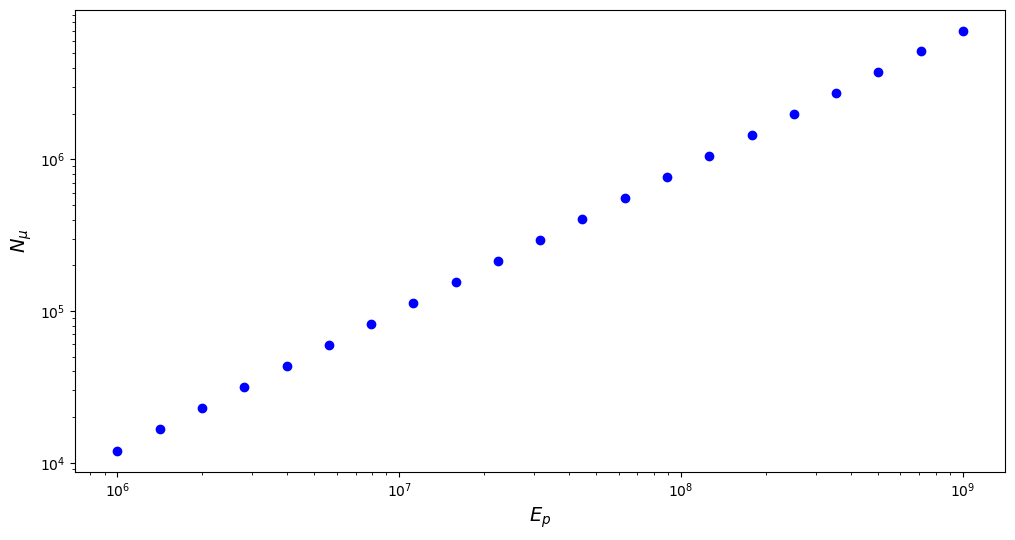

In [8]:
fig,ax = plt.subplots(1,1, figsize = (12,6))

ax.loglog(energies, muons, 'bo')
ax.set_xlabel(r'$E_p$', fontsize = 14)
ax.set_ylabel(r'$N_\mu$', fontsize = 14)

### <font color = 'darkblue'> **Part B** </font>
> Determine the value of $\alpha$ by fitting the relation between log $N_\mu$ and log $E_0$ with a straight line.

Recall that the number of muons is calculated using the following equation from the Heitler-Matthews model.
$$N_\mu = \left(\frac{E_0}{E_{dec}}\right)^\alpha$$ 
where $E_0$ is the energy of the primary particle, and $E_{dec}$ is the energy at which pions will decay into muons ($30\, GeV$). 

In [12]:
muons[1]
energies[1]

1412537.5446227554

In [25]:
def alpha_fit(x, alpha, c):
    fit_curve = alpha*x + c   # we need this offet for the curve fit

    return fit_curve

In [26]:
## Finding alpha
log_E0 = np.log10(energies) # returns the array as a log array
log_Nmu = np.log10(muons)

popt, pcov = scipy.optimize.curve_fit(alpha_fit, log_E0, log_Nmu)

In [27]:
print(popt[0])  # why 0?

0.922965252347345


look into why alpha fit must be a certain way

look into the output and what it means

In [17]:
E_dec = 30  # GeV

0.3509


In [39]:
popt

array([ 0.92296525, -1.45595478])

In [37]:
alpha_fit(log_E0, *popt)

array([4.08183673, 4.22028152, 4.35872631, 4.4971711 , 4.63561588,
       4.77406067, 4.91250546, 5.05095025, 5.18939504, 5.32783982,
       5.46628461, 5.6047294 , 5.74317419, 5.88161897, 6.02006376,
       6.15850855, 6.29695334, 6.43539813, 6.57384291, 6.7122877 ,
       6.85073249])

Text(0, 0.5, '$N_\\mu$')

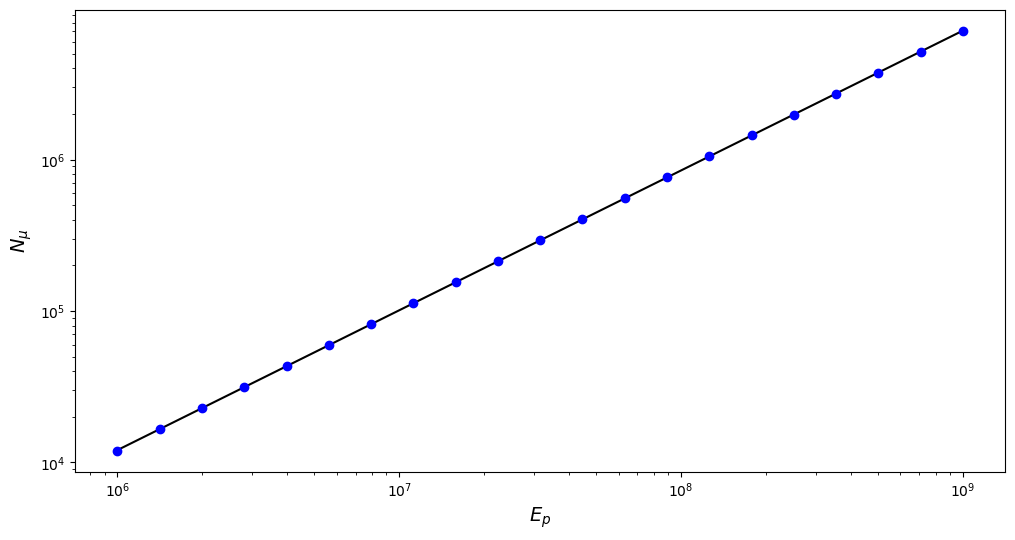

In [41]:
fig,ax = plt.subplots(1,1, figsize = (12,6))
alpha = 0.92

ax.plot(energies, 10**alpha_fit(log_E0, *popt), linestyle = '-', color = 'black')  # must fit on log scale
ax.loglog(energies, muons, 'bo')
ax.set_xlabel(r'$E_p$', fontsize = 14)
ax.set_ylabel(r'$N_\mu$', fontsize = 14)

## <font color = 'purple'> **Ex 2.3:**  Composition dependence of $X_{max}^\mu$ </font>

Air showers are dominated by the electromagnetic component, which reaches
a maximum number of particles at a depth $X_{max}$, after which it decreases due
to absorption of low-energy particles. The subdominant muon component of
air showers can similarly reach a maximum in lower-energy showers, because
low-energy muons will decay before reaching the surface of the Earth. Let us
call this depth $X_{max}^\mu$ and study how it depends on the mass $A$ of the primary.

### <font color = 'darkblue'> **Part A** </font>
> Use MCEq to obtain the number of muons, $N_\mu = N_{\mu^+} + N_{\mu^-}$ on a grid of $X$ values ranging from $0\, g/cm^2$ to $1030\, g/cm^2$ for a vertical $1\, PeV$ proton shower, in steps of $1\, g/cm^2$. Plot $N_\mu$ as a function of $X$ . This is the so-called longitudinal profile of the muon component of the shower.

In [ ]:
# Running the MCEq 
mceq = MCEqRun(

# High-energy hadronic interaction model
interaction_model='SIBYLL23C',

# cosmic ray flux at the top of the atmosphere
primary_model = (crf.HillasGaisser2012, 'H3a'),

# zenith angle
theta_deg = 0.  # Set to 0 for vertical showers
)
mceq.set_single_primary_particle(1e7, pdg_id=2212) # 10 PeV proton - Units are in GeV

mceq.solve()

### <font color = 'darkblue'> **Part B** </font>
> Find $X_{max}^\mu$ , the grid point of depth $X$ where $N_\mu$ reaches its maximal value.

In [ ]:
#

### <font color = 'darkblue'> **Part C** </font>
> Repeat this for $1\, PeV$ showers initidated by helium, carbon, silicon, and iron nuclei. Does $X_{max}^\mu$ have an approximately linear relationship to ln $A$ , as is expected for the regular shower maximum $X_{max}$ ?

In [63]:
#